In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     dataloading  Index.ipynb  output		     README.md	       transforms
config.yaml  experiments  index.py     preprocess	     requirements.txt  visualization
data	     Index_bc.py  models       project-structure.md  run.yaml


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder


In [13]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor
from dataloading.datareader import DataReader
from dataloading.dataset import CustomDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model
from models.unet import UNet

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester

In [6]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [7]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'k-fold', 'k': 10, 'val_percentage': 20, 'loss': 'mse', 'batch_interval': 512, 'epoch_interval': 1, 'num_epochs': 10}, 'model': {'name': 'unet', 'optimizer': 'Adam', 'lr': 0.001, 'weight_decay': 1e-08, 'amsgrad': False, 'momentum': 0.9}, 'test_model': False}


In [8]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [9]:
#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

#preprocess data or load preprocessed data
dr = DataReader()
ds = dr.get_split_data()
Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)
print('Full Train data length:', ftr_len)
print('Test data length:', te_len, '\n')

#transform data
composed_transforms =  transforms.Compose([
    ToTensor(True)
])

#convert to dataset
ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len, composed_transforms)
te_dataset = CustomDataset(Lte, ABte, te_len, composed_transforms)


Shape of X and y: (50000, 1, 32, 32) (50000, 2, 32, 32)
Full Train data length: 50000
Test data length: 10 



In [10]:
# model import
if exp_params['model']['name'] == 'unet':
    model = UNet()
else:
    raise SystemExit("Error: Invalid model name passed! Check run.yaml")

Running split 0
	Running Epoch 0
		Running through train dataset
		Running through validation dataset
	Epoch 0 Training Loss: 0.032131572858568026
	Epoch 0 Validation Loss: 0.02723237475147471
	Epoch 0 Validation Accuracy: 0.0

	Running Epoch 1
		Running through train dataset
		Running through validation dataset
	Epoch 1 Training Loss: 0.02556886395243716
	Epoch 1 Validation Loss: 0.022798906138632447
	Epoch 1 Validation Accuracy: 0.0

	Running Epoch 2
		Running through train dataset
		Running through validation dataset
	Epoch 2 Training Loss: 0.022432681097680787
	Epoch 2 Validation Loss: 0.021032995078712702
	Epoch 2 Validation Accuracy: 0.00019531250291038305

	Running Epoch 3
		Running through train dataset
		Running through validation dataset
	Epoch 3 Training Loss: 0.02071705150195736
	Epoch 3 Validation Loss: 0.02047455531428568
	Epoch 3 Validation Accuracy: 0.0

	Running Epoch 4
		Running through train dataset
		Running through validation dataset
	Epoch 4 Training Loss: 0.01973

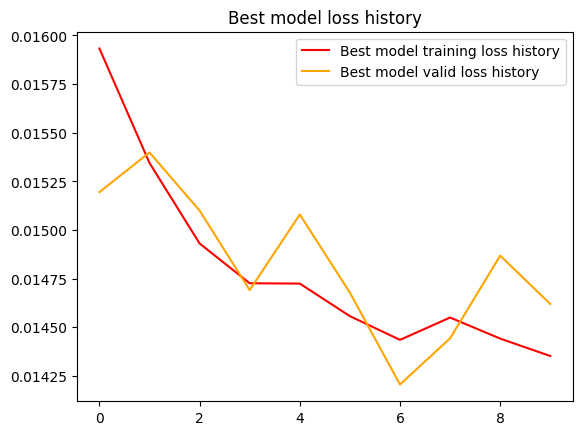


Best Model Loss: 0.013391107396455482
Best Model Accuracy: 0.0


Last model results




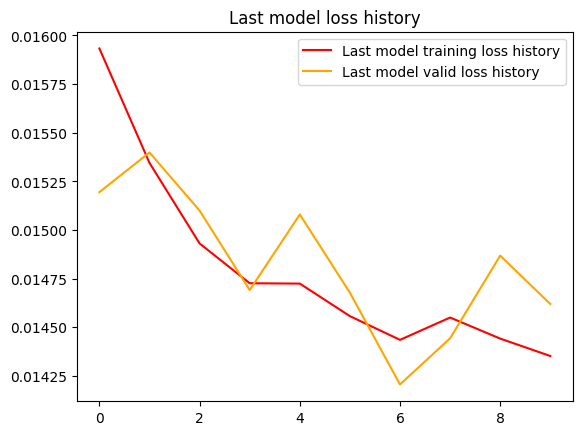


Last Model Loss: 0.01461980012158165
Last Model Accuracy: 0.0




In [11]:
#model training

exp = Experiment(model, ftr_dataset)
model_info = exp.train()
print("\nModel validation results")

#visualization results
vis = Visualization(model_info)
vis.get_results()

#save model of your choice
exp.save_model(model_info["best_model"], model_info, 'best_model')




Testing Saved Model


<Figure size 640x480 with 0 Axes>

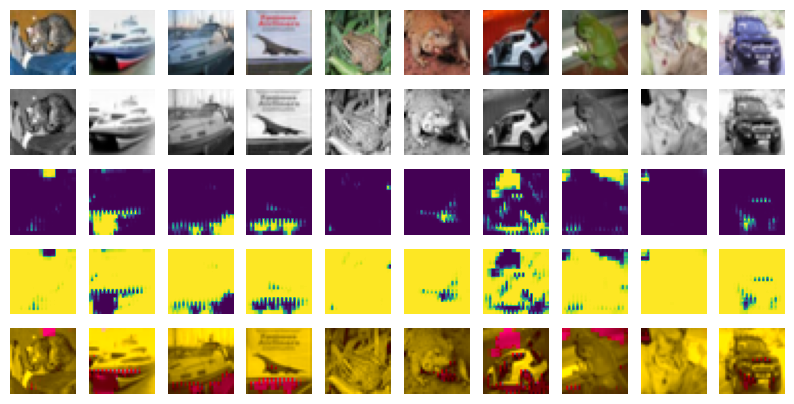


Test Loss: 0.44564467668533325
Test Accuracy: tensor(0.) 



In [27]:
#model testing

model = get_saved_model(model, '')

print("\n\nTesting Saved Model")
mt = ModelTester(model, te_dataset)
mt.test_and_plot(ds["RGBte"], "best_model", True)